In [1]:
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
color_map = {
    'solar': 'yellow',
    'wind': 'lightblue',
    'lithium_ion_lfp_store': 'green',
    'nuclear': 'orange',
    'natgas': 'gray',
    'oil': 'black',
    'h2_storage': 'lightpink',
    'BTES': 'red'}

/var/folders/mb/bhrh7_m94j739pkhyn5p1l3w0000gn/T/ipykernel_84771/2234436540.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  data = pickle.load(f)


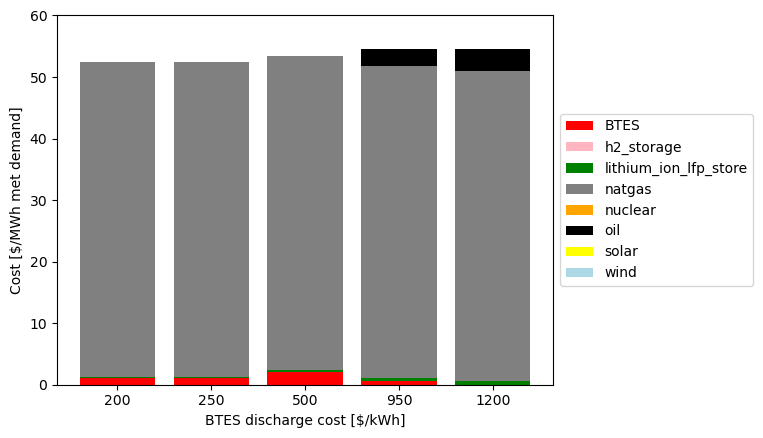

In [7]:
output_path = 'output_data/btes_base_case_orca/'

plt.figure()
file_names = [f for f in os.listdir(output_path) if (f.endswith('.pickle') and not 'Store' in f)]
for btes_file in sorted(file_names, key=lambda x: float(x.split('_')[-1].split('.')[0])):

    if not btes_file.endswith('.pickle'):
        continue
    btes_discharge_cost = btes_file.split('_')[-1].split('.')[0]

    with open(os.path.join(output_path, btes_file), 'rb') as f:
        data = pickle.load(f)
        component_data = data['component results']
        cost = component_data['Capital Expenditure [$]'] + component_data['Operational Expenditure [$]']
        # Drop the first index (component type)
        cost = cost.droplevel(0)
        # Add components with same name but keep the names
        cost = cost.groupby(cost.index).sum()
        # Divide by total met demand i.e. withdrawal of load
        total_met_demand = data['component results']['Withdrawal [MW]']['Load'].sum()
        cost = cost / total_met_demand
        # Drop load
        cost = cost.drop('load')

        # Make stack bar plot with cost at btes_discharge_cost
        for i, (name, cost_value) in enumerate(cost.items()):
            plt.bar(str(btes_discharge_cost), cost_value, bottom=cost[:i].sum(), label=name, color=color_map[name])


plt.xlabel('BTES discharge cost [$/kWh]')
plt.ylabel('Cost [$/MWh met demand]')
plt.ylim(0, cost.sum()*1.1)

# Add legend with unique names
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# Put legend outside of plot
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
